# Step4. Evaluating Linear Regression Model

Goal: 
- Use the best model (in Step 3) and evaluate its performance

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import power_transform
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

from ScrapeProcFunc import *

import warnings
warnings.simplefilter('ignore')

In [2]:
# Import dataset
df = pd.read_csv('./data/Allplayers.csv', index_col=0)

In [3]:
# Select columns to use or NOT use
Xorig = df.drop(['pos_QB','draftStat_No', 'Salary_log1p'],axis=1)
yorig = df['Salary_log1p']

print(Xorig.shape)
Xorig.sample()

(356, 11)


,draftRnd,ht_inch,Wt,dash,yr1,yr2,yr3,yr4,pos_RB,pos_WR,draftStat_Yes
169,0,74,214,4.65,0.0,0.0,0.0,0.0,0,1,0


In [5]:
# Hold out 20% of the data for final testing: TRAIN and TEST
X_train, X_test, y_train, y_test = train_test_split(Xorig, yorig, test_size=.2, random_state=10)


### Selecting the best model to use for the Test Set
### >>>>>> Simple Linear Regression <<<<<<
- Now, use this model to train on the entire dataset, and make predictions on the **test set**

In [6]:
sc = StandardScaler()
sc.fit(X_train.values)
X_train_sc = sc.transform(X_train)
X_test_sc = sc.transform(X_test)

In [7]:
# Training on the entire training set
simple_lr = LinearRegression()
simple_lr.fit(X_train_sc, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [8]:
# Testing on the TEST SET.....!
y_test_pred = simple_lr.predict(X_test_sc)
test_residuals = y_test - y_test_pred

In [14]:
# Final result 

y_test_pred = simple_lr.predict(X_test_sc)

rmse_final = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_result = r2_score(np.asarray(y_test), np.asarray(y_test_pred))

print('RMSE of Test Set: ', rmse_final)
print('R2   of Test Set: ', r2_result)

RMSE of Test Set:  0.6244911797016752
R2   of Test Set:  0.3501001200726309


**RESULT:**
- It's an OK model, considering it's just a simple multivariate linear regression model 
- low R2, but it's a good start! and definitely better than random guessing (R2 =0)

---

### Now convert prediction result into Salaries in USD

In [15]:
# Converting yvalues back to $$
df_ytest = pd.DataFrame(np.exp(y_test)-1)
df_ytest.columns = ['Salary']
df_ytest.head()

,Salary
27,900715.00
20,893466.75
37,600600.00
6,6435000.00
49,628650.00


In [16]:
# Converting ypred back to $$

df_ypred = pd.DataFrame(np.exp(y_test_pred)-1, columns =['Salary'])
df_ypred.head()

,Salary
0,8.757215e+05
1,1.222194e+06
2,5.964578e+05
3,1.992000e+06
4,9.036352e+05


In [17]:
# Calculate RMSE, in terms of salaries world
rmse = np.sqrt(mean_squared_error(np.asarray(df_ytest), np.asarray(df_ypred)))

print('How off is my prediction? ${}'.format(round(rmse)))


How off is my prediction? $1130142.0


In [18]:
# Summary of y values 
df_y_summary = pd.concat([df_ytest.reset_index(),df_ypred.reset_index()], axis=1)
df_y_summary = df_y_summary.drop(columns = ['index'])

### Check out the overall performance of the model, with respect to the test set 

In [19]:
df_y_summary.columns = ['True','Predicted']

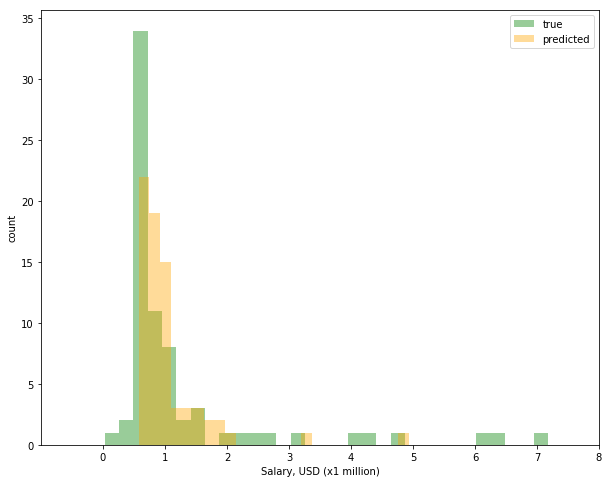

In [20]:
# plt.figure(figsize=(12,8))

fig,axes = plt.subplots(figsize=(10,8))
sns.distplot( df_y_summary.iloc[:,[0]] , color="green", label="true", kde=False)
sns.distplot( df_y_summary.iloc[:,[1]] , color="orange", label="predicted" , kde=False)
plt.xlim([-1e6, 8000000])
plt.xticks([0.,  1000000.,  2000000.,  3000000.,  4000000.,
         5000000.,  6000000.,  7000000.,  8000000.], [str(x) for x in range(0,10,1 )]);
plt.xlabel('Salary, USD (x1 million)')
plt.ylabel('count')
plt.legend()
plt.savefig('./figures/ytest_ypred_histo.png');



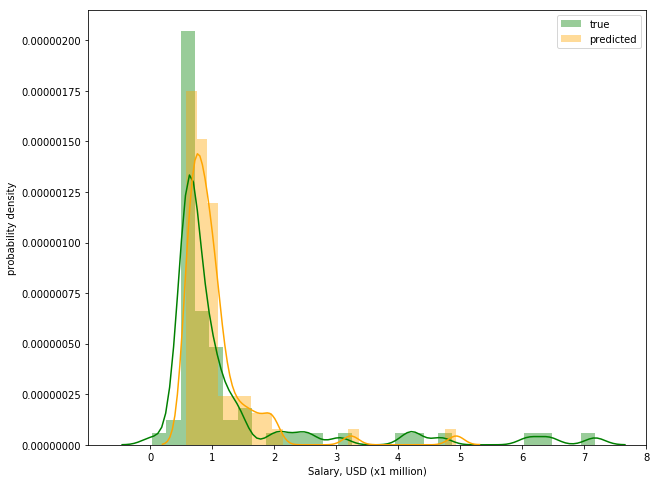

In [21]:
# plt.figure(figsize=(12,8))

fig,axes = plt.subplots(figsize=(10,8))
sns.distplot( df_y_summary.iloc[:,[0]] , color="green", label="true")
sns.distplot( df_y_summary.iloc[:,[1]] , color="orange", label="predicted")
plt.xlim([-1e6, 8000000])
plt.xticks([0.,  1000000.,  2000000.,  3000000.,  4000000.,
         5000000.,  6000000.,  7000000.,  8000000.], [str(x) for x in range(0,10,1 )]);
plt.xlabel('Salary, USD (x1 million)')
plt.ylabel('probability density')
plt.legend()
plt.savefig('./figures/ytest_ypred_histo_kde.png');



Notes:
- Lineshapes are fairly similar, with some discrepancies
- The model is overly confident in predicting lower-range Salaries, and misses the mark on the higher-income range 
- Error (RMSE) is ~1.1 million

---